# Compare CASTEP DNA benchmark performance

This notebook compares the performance of the large DNA benchmark across different UK HPC facilities.

Facilities included:

+ [Cirrus@EPCC](http://www.cirrus.ac.uk): HPE/SGI Ice XA. Two 2.1 GHz 18-core Xeon (Broadwell) per node. FDR hypercube
+ [ARCHER](http://www.archer.ac.uk): Cray XC30. Two 2.7 GHz 18-core Xeon (IvyBridge) per node. Cray Aries dragonfly.

Other UK Tier-2 facilities are not included as they do not (by default) allow jobs large enough to run this benchmark.

## Setup section

Import the required modules and define useful functions.

In [2]:
import re
import numpy as np
from scipy import interpolate
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("white", {"font.family": "serif"})
sns.set_context("paper")

Define a function to get the mean SCF cycle time from CASTEP output file. Minimum and maximum times found are removed before mean is computed to remove skewing due to long first step or very short step.

In [3]:
def getmeancycle(castepfilename):
    infile = open(castepfilename, 'r')
    tvals = []
    for line in infile:
        if re.search('<-- SCF', line):
            line = line.strip()
            tokens = line.split()
            if re.match('[0-9]+', tokens[0].lstrip()):
                tvals.append(float(tokens[4]))
    infile.close()

    deltat = []
    for i in range(len(tvals)-1):
        deltat.append(tvals[i+1] - tvals[i])
        
    deltat.remove(max(deltat))
    deltat.remove(min(deltat))
    
    return sum(deltat)/len(deltat)

Define a function to setup arrays of performance data for each system. Takes dictionary of CASTEP output files keyed by number of nodes and the number of cores per node. (Assumes all nodes are fully-populated.) Also print a summary of the data.

In [4]:
def calcperf(filedict, cpn):
    coreslist = []
    scflist = []
    sulist = []
    print "{:>15s} {:>15s} {:>15s} {:>15s}".format('Nodes', 'Cores', 'Mean SCF (s)', 'Speedup')
    print "{:>15s} {:>15s} {:>15s} {:>15s}".format('=====', '=====', '============', '=======')
    for nodes, filename in sorted(filedict.items()):
        coreslist.append(nodes*cpn)
        scf = getmeancycle(filename)
        scflist.append(scf)
        speedup = scflist[0]/scf
        sulist.append(speedup)
        print "{:>15d} {:>15d} {:>15.1f} {:>15.2f}".format(nodes, nodes*cpn, scf, speedup)
    return coreslist, scflist, sulist

## Read data and compute performance

### Cirrus

Cirrus results run up to 272 nodes as the maximum size on the system is 280 nodes (which is the whole machine).

Cirrus results are for CASTEP 16.11 compiled with Intel 17.0.2.174 and SGI MPT 2.14. BLAS/LAPACK were provided by Intel MKL 17.0.2.174 and FFTW by FFTW 3.3.5.

In [5]:
cirrusmptfiles = {70:'../DNA/results/Cirrus/16.11_intel17_mpt214/polyA20-no-wat.castep.70nodes',
                  135:'../DNA/results/Cirrus/16.11_intel17_mpt214/polyA20-no-wat.castep.135nodes',
                  272:'../DNA/results/Cirrus/16.11_intel17_mpt214/polyA20-no-wat.castep.272nodes'}

In [6]:
cirrusmptcpn = 36
cirrusmptcores, cirrusmptscf, cirrusmptsu = calcperf(cirrusmptfiles, cirrusmptcpn)

          Nodes           Cores    Mean SCF (s)         Speedup
          =====           =====    ============         =======
             70            2520          2038.3            1.00
            135            4860          1256.8            1.62
            272            9792           870.8            2.34


### ARCHER

ARCHER results are for CASTEP 17.21 compiled with GCC 6.3.0 and Cray MPICH 7.5.5. BLAS/LAPACK were provided by Intel MKL 17.0.0.098 and FFTW by Cray FFTW 3.3.4.11.

In [7]:
archerfiles = {100:'../DNA/results/ARCHER/polyA20-no-wat.castep.100nodes',
               125:'../DNA/results/ARCHER/polyA20-no-wat.castep.125nodes',
               250:'../DNA/results/ARCHER/polyA20-no-wat.castep.250nodes',
               500:'../DNA/results/ARCHER/polyA20-no-wat.castep.500nodes',
               1000:'../DNA/results/ARCHER/polyA20-no-wat.castep.1000nodes',
               2000:'../DNA/results/ARCHER/polyA20-no-wat.castep.2000nodes'}

In [8]:
archercpn = 24
archercores, archerscf, archersu = calcperf(archerfiles, archercpn)

          Nodes           Cores    Mean SCF (s)         Speedup
          =====           =====    ============         =======
            100            2400          1416.3            1.00
            125            3000          1163.3            1.22
            250            6000           603.6            2.35
            500           12000           389.3            3.64
           1000           24000           235.8            6.01
           2000           48000           178.4            7.94


## Performance Comparison

### Mean SCF cycle time

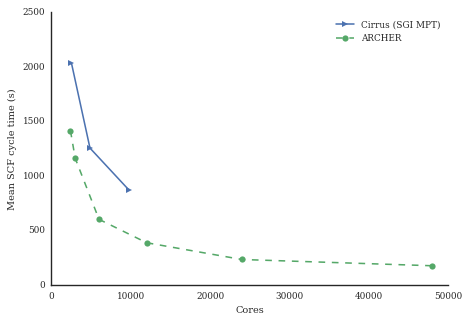

In [9]:
plt.plot(cirrusmptcores, cirrusmptscf, '>-', label='Cirrus (SGI MPT)')
plt.plot(archercores, archerscf, 'o--', label='ARCHER')
plt.xlabel('Cores')
plt.ylabel('Mean SCF cycle time (s)')
plt.legend(loc='best')
sns.despine()

### Speedup (relative to 1 node)

Here, we want to plot per-node rather than per-core as we are using fully-populated nodes and all speedups are relative to 1 node performance on the same system.

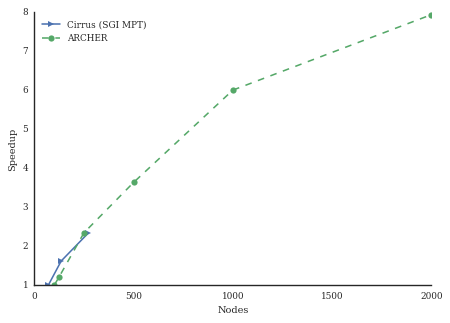

In [10]:
plt.plot([x/cirrusmptcpn for x in cirrusmptcores], cirrusmptsu, '>-', label='Cirrus (SGI MPT)')
plt.plot([x/archercpn for x in archercores], archersu, 'o--', label='ARCHER')
plt.xlabel('Nodes')
plt.ylabel('Speedup')
plt.legend(loc='best')
sns.despine()

### ARCHER vs. Cirrus comparison

Exact comparison is difficult as ARCHER and Cirrus use different node/core counts. However, we can fit the ARCHER performance to a simple function (as we have enough datapoints) and extrapolate to the same core counts as Cirrus.

          Cores  Cirrus Mean SCF (s)  ARCHER Intr. SCF (s)   Cirrus/ARCHER
          =====  ===================  ====================   =============
           2520               2038.3                1360.3           1.498
           4860               1256.8                 720.8           1.744
           9792                870.8                 426.3           2.043


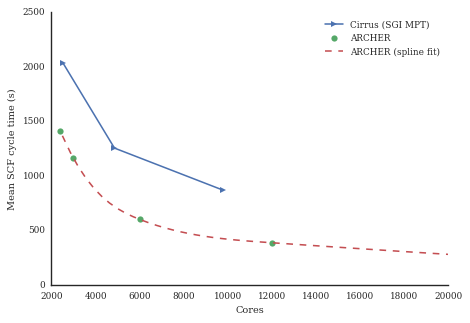

In [11]:
# Function to interpolate point from spline coeffs
def f(x, coeff):
    return interpolate.splev(x, coeff)

# Fit cubic spline to ARCHER data
archercf = interpolate.splrep(archercores, archerscf)

# Loop over Cirrus datapoints comparing performance
print "{:>15s} {:>20s} {:>21s} {:>15s}".format('Cores', 'Cirrus Mean SCF (s)', 'ARCHER Intr. SCF (s)', 'Cirrus/ARCHER')
print "{:>15s} {:>20s} {:>21s} {:>15s}".format('=====', '===================', '====================', '=============')
for i, jobsize in enumerate(cirrusmptcores):
    archerperf = float(f(jobsize, archercf))
    print "{:>15d} {:>20.1f} {:>21.1f} {:>15.3f}".format(jobsize, cirrusmptscf[i], archerperf, cirrusmptscf[i]/archerperf)

# Plot to compare fit to data
xp = np.linspace(2500, 20000)
plt.plot(cirrusmptcores, cirrusmptscf, '>-', label='Cirrus (SGI MPT)')
plt.plot(archercores, archerscf, 'o', label='ARCHER')
plt.plot(xp, f(xp, archercf), '--', label='ARCHER (spline fit)')
plt.xlabel('Cores')
plt.ylabel('Mean SCF cycle time (s)')
plt.xlim(2000,20000)
plt.legend(loc='best')
sns.despine()